# HyperLogLog counters for finding the Graph Nodes with the highest centrality

> Nikolaos Smyrnioudis - nsmy@kth.se

Implementation of the algorithm in "In-Core Computation of Geometric Centralities with HyperBall: A Hundred Billion Nodes and Beyond" and application to the Wikispeedia graph dataset.

In [57]:
from urllib.parse import unquote
import csv

In [58]:
# Data mining homework 3

In [59]:
!ls wikispeedia_paths-and-graph/

articles.tsv	links.tsv	    paths_unfinished.tsv
categories.tsv	paths_finished.tsv  shortest-path-distance-matrix.txt


In [60]:
# We use the wikispeedia dataset. Number of nodes: 4604, Number of edges: 119882

In [61]:
!head -n 17 wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt

# The shortest-path distances between all pairs of articles, computed using the Floyd-Warshall algorithm.
# FORMAT:
# One row per article (the "source" of the shortest paths), in the same order as in articles.tsv.
# Each row contains the distances from the source to all articles (the "targets" of the shortest paths),
# again in the order of articles.tsv.
# The shortest-path distance is represented as a single digit, with no separators between values. This
# is possible because the longest shortest path happens to be of length 9.
# An underscore ("_") is used to indicate that the target cannot be reached from the source.
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conf

In [62]:
!head -n 15 wikispeedia_paths-and-graph/links.tsv

# The list of all links between articles.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   linkSource   linkTarget
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in	Bede
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in	Columba
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in	D%C3%A1l_Riata


In [63]:
!head -n 15 wikispeedia_paths-and-graph/articles.tsv

# The list of all articles.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
%C3%85land
%C3%89douard_Manet


In [79]:

def remove_comments(reader):
    for elem in reader:
        if not "".join(elem).startswith("#") and len(elem) > 0:
            yield elem
            
def url_decode(reader):
    for elem in reader:
        yield [unquote(x) for x in elem]
        
def get_articles():
    f = open("wikispeedia_paths-and-graph/articles.tsv")
    reader = csv.reader(f, delimiter="\t", quotechar='"')
    reader = url_decode(remove_comments(reader))
    return reader , f

def get_links():
    f = open("wikispeedia_paths-and-graph/links.tsv")
    reader = csv.reader(f, delimiter="\t", quotechar='"')
    reader = url_decode(remove_comments(reader))
    return reader , f


In [96]:
articles = []
reader ,f = get_articles()
article2i = {}
for i, x in enumerate(reader):
    articles.append(x[0])
    article2i[x[0]] = i

In [97]:
f.close()

In [301]:
# Building adjacency list
from collections import defaultdict
adj_list = defaultdict(lambda : set())
links_iter, f = get_links()
# We create the graph transpose, because it is necessary in further analysis
for u,v in tqdm(links_iter):
    if u != v:
        adj_list[v].add(u)
    
for article in articles:
    if article not in adj_list:
        adj_list[article] = set()
f.close()

0it [00:00, ?it/s]

In [302]:
degrees = [len(adj_list[article]) for article in articles]

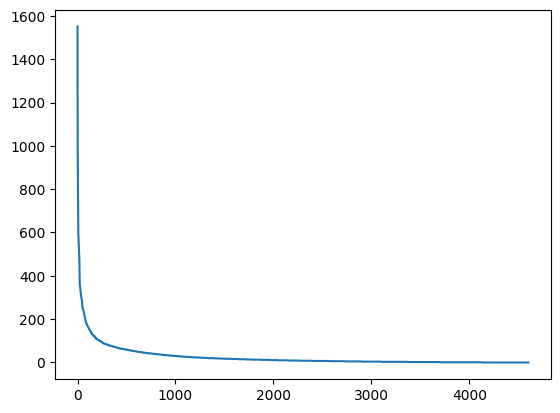

In [303]:
# Degrees seem to follow a log normal distribution
plt.plot(sorted(degrees, reverse=True))

# Paper 3, in this paper the authors use HyperBall for computation of Geometric Centralities

In [244]:
from hashlib import sha1, sha256

In [245]:
hash_digest = sha1("Edouard".encode('utf8')).hexdigest()

In [246]:
hash_digest

'c5ec008b38803f686713aefda75d554d91d1868b'

In [247]:
len(hash_digest)

40

In [248]:
int_hash = int(hash_digest, 16)

In [249]:
int_hash

1129934205093501283171060625178435910280609367691

In [250]:
int_hash.bit_length()

160

In [251]:
bin(int_hash)

'0b1100010111101100000000001000101100111000100000000011111101101000011001110001001110101110111111011010011101011101010101010100110110010001110100011000011010001011'

In [252]:
format(int_hash, '0256b')

'0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100010111101100000000001000101100111000100000000011111101101000011001110001001110101110111111011010011101011101010101010100110110010001110100011000011010001011'

In [253]:
def h_sub(t : int, x : int):
    """
    leftmost t bits of h(x)
    """
    return format(x, '0160b')[:t]

def h_over(t:int, x : int):
    """
    remaining bits of hsub(t,x)
    """
    return format(x, '0160b')[t:]

In [254]:
h_sub(5,int_hash)

'11000'

In [255]:
h_over(5,int_hash)

'10111101100000000001000101100111000100000000011111101101000011001110001001110101110111111011010011101011101010101010100110110010001110100011000011010001011'

In [256]:
(h_sub(5, int_hash ) + h_over(5,int_hash) ) == bin(int_hash)[2:]

True

In [257]:
h_sub(5, int_hash ), h_over(5,int_hash), bin(int_hash)[2:]

('11000',
 '10111101100000000001000101100111000100000000011111101101000011001110001001110101110111111011010011101011101010101010100110110010001110100011000011010001011',
 '1100010111101100000000001000101100111000100000000011111101101000011001110001001110101110111111011010011101011101010101010100110110010001110100011000011010001011')

In [258]:
bin(15)

'0b1111'

In [259]:
def leading_zeroes(x : str):
    """
    x binary str
    """
    cnt = 0
    i = 0
    while i < len(x):
        if x[i] == '0':
            cnt+=1
            i += 1
        else:
            break
    return cnt + 1
leading_zeroes("00101")        

3

In [260]:
def alpha(p):
    valid_inputs = [2 ** x for x in range(4,17)]
    assert p in valid_inputs, "The parameter b must be in [4,16], other \
    wise we don't have an estimation of the bias correction term"
    if p == 16:
        return 0.673
    elif p == 32:
        return 0.697
    elif p == 64:
        return 0.709
    else:
        return 0.7213 / (1 + (1.079 / p))

In [261]:
alpha(2048)

0.7209201792610241

In [262]:
import numpy as np

In [263]:
# Here we go
def ezhash(elem: str):
    digest = sha1(elem.encode('utf8')).hexdigest()
    return int(digest, 16)


class HyperLogLog:
    def __init__(self, b):
        self.b = b 
        self.p = 2**b
        self.M = [0 for x in range(self.p)]
        self.a_p = alpha(self.p)
    
    def add(self, item : str):
        hash_value = ezhash(item)
        i = int(h_sub(self.b, hash_value), 2)
        self.M[i] = max(self.M[i], leading_zeroes(h_over(self.b, hash_value)))
        
    @staticmethod
    def union_static(c1 : HyperLogLog, c2: HyperLogLog):
        """
        Produces a new hyperloglog counter which is the union of the given counters
        """
        assert len(c1.M) == len(c2.M), "The two counters must have the same number of registers for the union"
        new_counter = HyperLogLog(self.b)
        for i in range(len(self.M)):
            new_counter.M[i] = max(self.M[i], c2.M[i])
        return new_counter
    
    def union(self, c2 : HyperLogLog):
        """
        Modifies the current new hyperloglog counter to be the union of the given counters
        """
        assert len(self.M) == len(c2.M), "The other counter must have the same number of registers for the union"
        for i in range(len(self.M)):
            self.M[i] = max(self.M[i], c2.M[i])
        return self
        
    
    def size(self):
        Z = 1 / sum([ (2 ** -self.M[j]) for j in range(0, self.p)])
        E = self.a_p * (self.p**2) * Z
        # Small range correction 
        if E < 5/2 * self.p: # Can happen if we have set b too high and there are very few elements 
            V = sum([1 for x in self.M if x == 0])
            if V != 0:
                return self.p * np.log(self.p / V)
            else:
                return E
        else:
            return E

In [264]:
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

  0%|          | 0/100 [00:00<?, ?it/s]

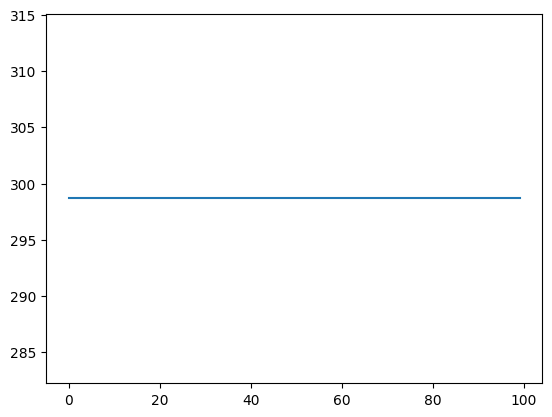

In [265]:
sizes = []
for x in tqdm(range(100)):
    elements = ["a" * x for x in range(1, 300)] # 300 distinct elements
    occurences = [random.randint(1, 20) for x in range(len(elements))]
    series = [ elements[i] for i in range(len(elements)) for _ in range(occurences[i])]
    counter = HyperLogLog(16)
    for elem in series:
        counter.add(elem)
    sizes.append(counter.size())
    
plt.plot(sizes)

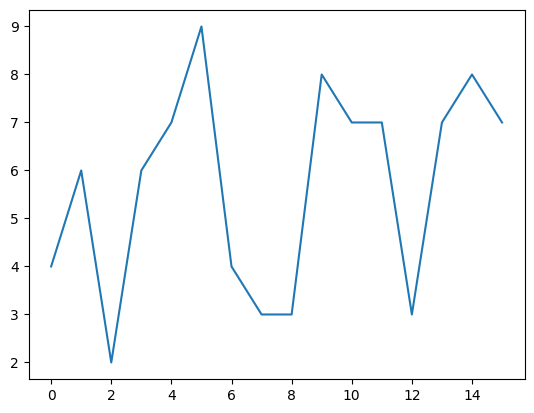

207.55636705882353


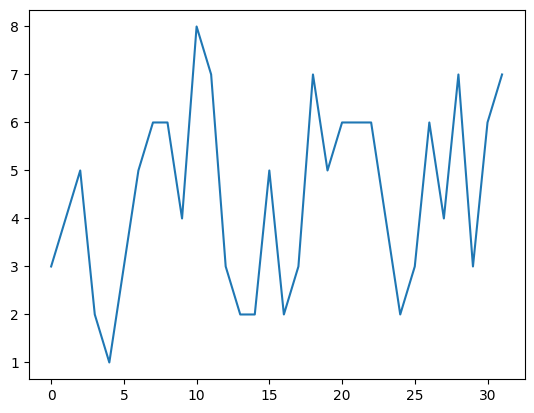

236.37046313065977


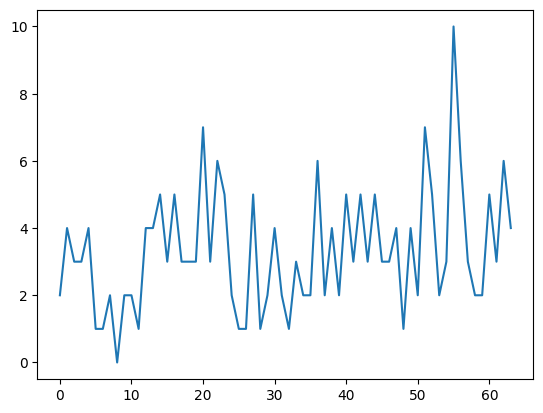

251.48089099365748


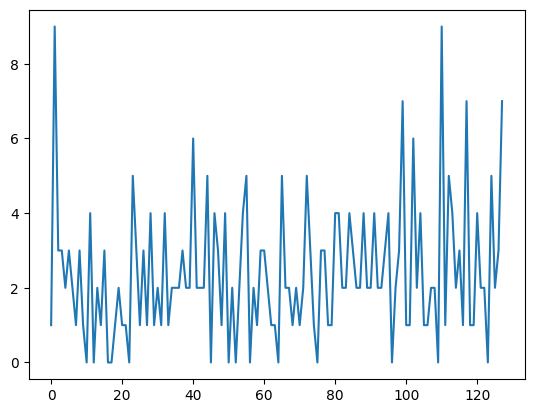

283.2605355909579


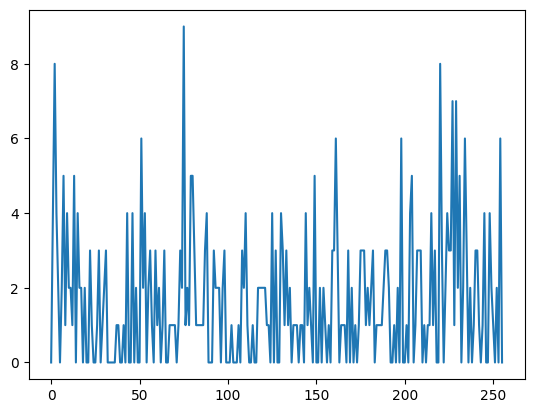

285.27632528287967


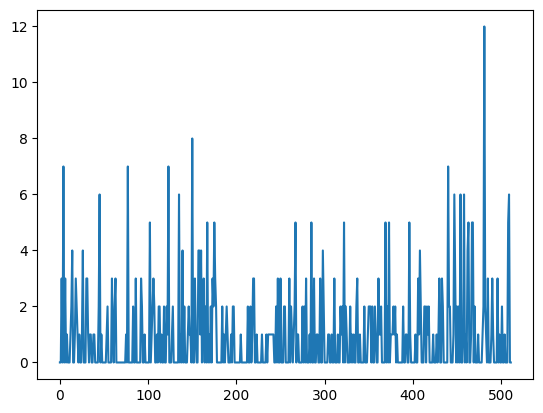

287.5242612588677


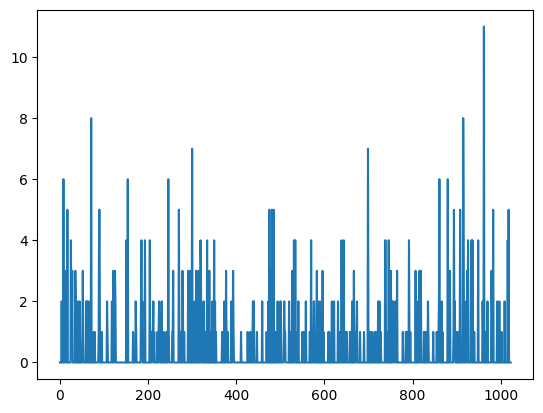

294.5864421906236


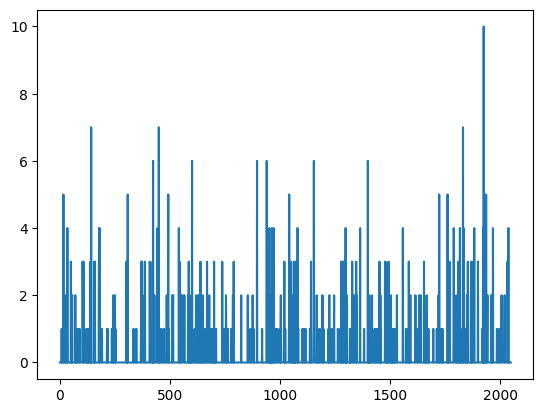

301.08619358578636


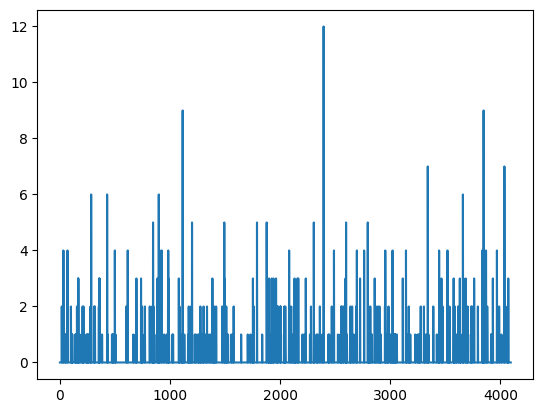

299.701904739723


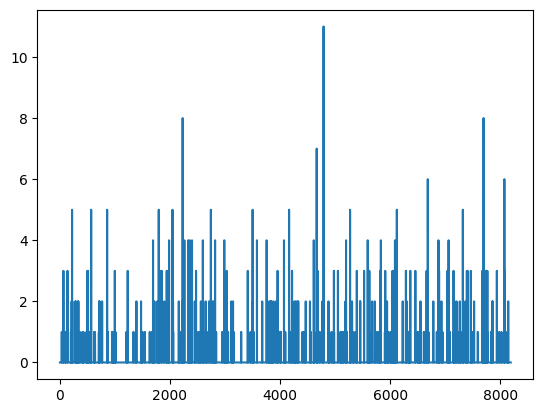

301.48006843163915


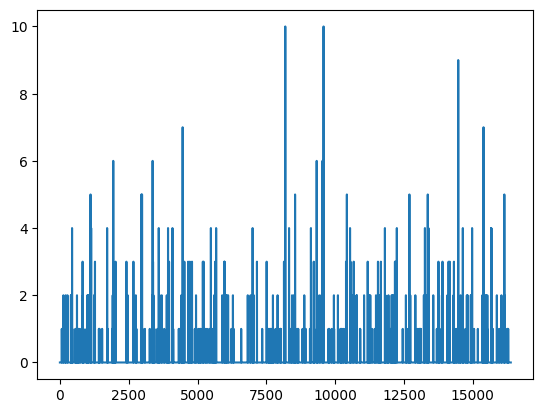

302.78057692479064


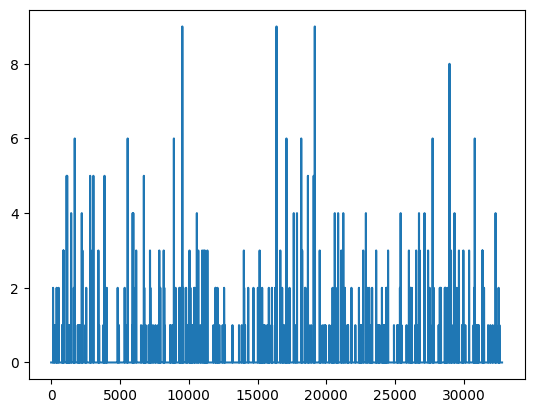

301.3817308975363


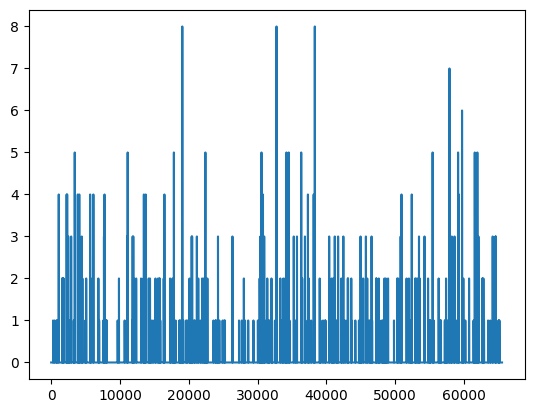

300.68874820429545


In [266]:
import time
import string
def randstr(N):
    return ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(N))
    
#elements = ["a" * x for x in range(1, 299)] # 300 distinct elements   
elements = [randstr(500) for x in range(1, 301)] # 300 distinct elements   
for p in range(4,17):
    occurences = [random.randint(1, 150) for x in range(len(elements))]
    series = [ elements[i] for i in range(len(elements)) for _ in range(occurences[i])]
    counter = HyperLogLog(p)
    # Avxbynbf FZleavbhqvf
    for elem in series:
        counter.add(elem)
    plt.plot(counter.M)
    plt.show()
    print(counter.size())

In [304]:
# Test union
c = HyperLogLog(7)
c.add("aa")
c.add("aaa")
c.add("aaaa")
print("c size ", c.size())

c2 = HyperLogLog(7)
c2.add("aa")
c2.add("aaaa")
c2.add("aaaaa")
print("c2 size ", c.size())

c.union(c2)
print("union size ", c.size())

c size  3.0357154070164563
c2 size  3.0357154070164563
union size  4.063833384266275


In [305]:
import copy
def compute_metrics(adj_list, articles, article2i, max_iters=1000):
    c = [HyperLogLog(7) for _ in range(len(articles))]
    sum_of_distances_per_node = [0 for _ in range(len(articles))]
    sum_of_reciprocals_per_node = [0 for _ in range(len(articles))]
    sizes_of_coreachable_sets = [0 for _ in range(len(articles))]
    # Add the 1 ball for the counters
    for i, article in enumerate(articles):
        c[i].add(article)
        sum_of_distances_per_node[i] += len(adj_list[article])
        if len(adj_list[article]) > 0:
            sum_of_reciprocals_per_node[i] += (len(adj_list[article]))
    
    counters_have_updated = True
    n_iters = 0
    pbar = tqdm(total=15)
    increments = []
    with pbar:
        while n_iters < max_iters and counters_have_updated:
            counters_have_updated = False
            new_sizes = [0 for _ in range(len(articles))]
            new_counters = [None for i in range(len(articles))]
            for v in adj_list:
                v_counter = copy.deepcopy(c[article2i[v]])
                assert v_counter is not None
                prev_size = v_counter.size()
                for w in adj_list[v]:
                    # Edge v-> w 
                    w_counter = c[article2i[w]]
                    assert w_counter is not None
                    v_counter = v_counter.union(w_counter)
                curr_size = v_counter.size()
                # Nikolaos Smyrnioudis
                new_counters[article2i[v]] = v_counter
                # Ball size of size t for v node
                v_ball_size_t = curr_size - prev_size
                # In the first iteration of this segment we consider paths at distance starting t =2
                sum_of_distances_per_node[article2i[v]] += (n_iters + 2) * v_ball_size_t
                sum_of_distances_per_node[article2i[v]] += (1 / (n_iters + 2)) * v_ball_size_t
                increments.append(v_ball_size_t)
                if v_ball_size_t > 0:
                    counters_have_updated = True
                new_sizes[article2i[v]] = curr_size
                
            sizes_of_coreachable_sets = new_sizes
            c = new_counters
            plt.plot(sorted(new_sizes))
            plt.show()
            n_iters += 1
            pbar.update(1)
    plt.plot(increments)
    plt.show()
    
    return sum_of_distances_per_node, sum_of_reciprocals_per_node, sizes_of_coreachable_sets
    

  0%|          | 0/15 [00:00<?, ?it/s]

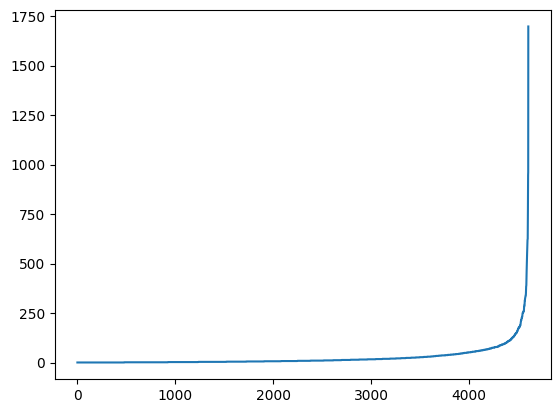

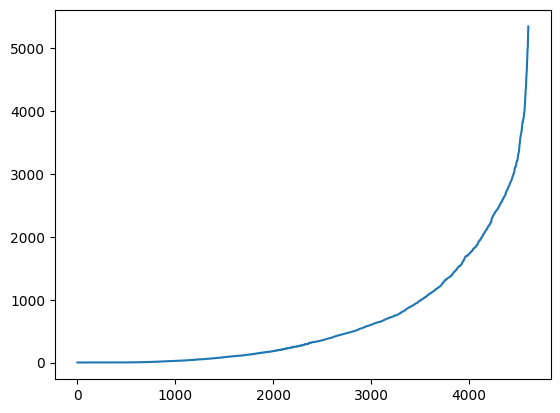

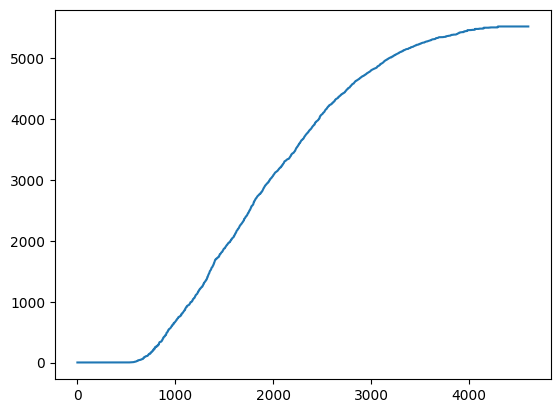

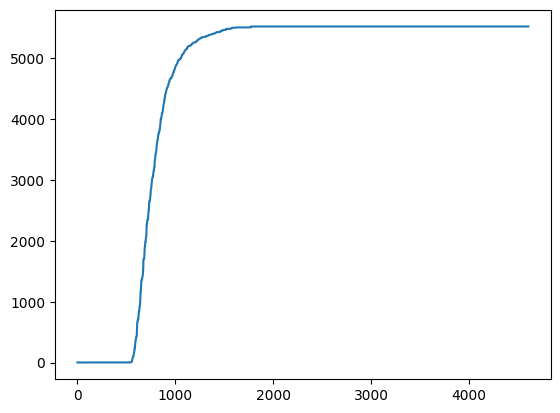

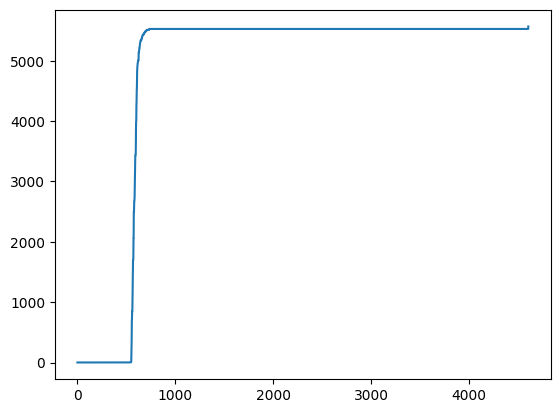

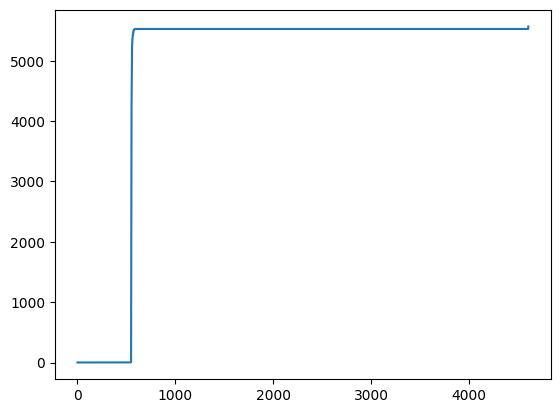

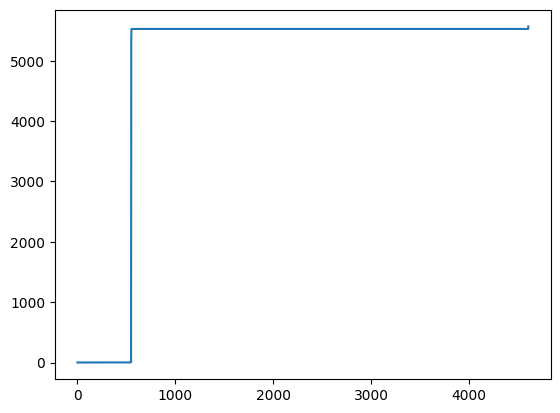

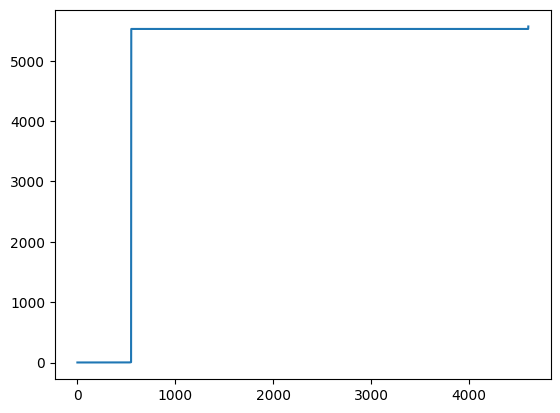

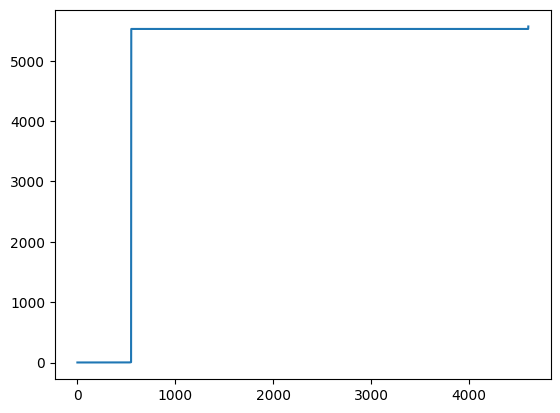

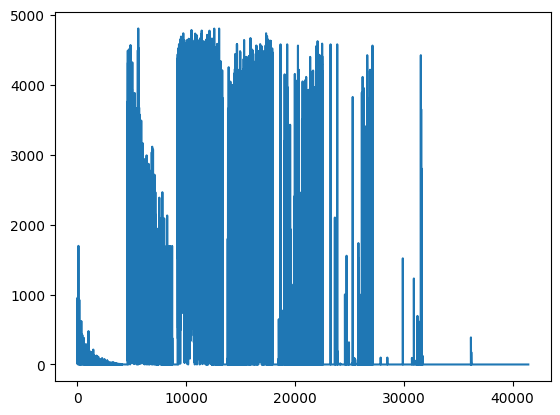

In [306]:
sdistance, sinvdist, scoset = compute_metrics(adj_list, articles, article2i, max_iters=1000)

In [307]:
# The algorithm only needs 9 iterations to converge

In [308]:
print("Wikipedia articles with 0 coreachable set")
ignore_articles = set()
for x in articles:
    if len(adj_list[x]) == 0:
        print(x)
        ignore_articles.add(x)

Wikipedia articles with 0 coreachable set
Áedán_mac_Gabráin
Åland
Édouard_Manet
Éire
Óengus_I_of_the_Picts
€2_commemorative_coins
2005_Hertfordshire_Oil_Storage_Terminal_fire
2005_Lake_Tanganyika_earthquake
A._E._J._Collins
AC_DC
ATLAS_experiment
A_Wrinkle_in_Time
Abacá
Abbadid
Abbas_I_of_Persia
Abraham_Goldfaden
Achilles_tendon
Actuary
Adi_Shankara
Adriaen_van_der_Donck
African_Black_Oystercatcher
African_Brush-tailed_Porcupine
African_Grey_Hornbill
African_Jacana
Albertosaurus
Albrecht_Rodenbach
Aleksey_Arakcheyev
Algoma_Central_Railway
All_your_base_are_belong_to_us
Amda_Seyon_I
Andrew_Gonzalez
Annibale_Bugnini
Antlion
Anton_Alexander_von_Werner
Apaochi
Aradia,_or_the_Gospel_of_the_Witches
Architecture_of_Windows_NT
Architecture_of_the_California_missions
Arp2_3_complex
Arthur_Upfield
Astrophysics_Data_System
Atlantic_herring
Australian_Ringneck
Australian_constitutional_law
Autobianchi_Primula
Automatic_number_plate_recognition
Autostereogram
Aye-aye
Baby_Gender_Mentor
Baden-Powell

In [309]:
# Because of the wikispeedia dataset, the paths people take usually will start from articles that are very specific
# In their paths the people will likely no go back to the same article as they started, 
# which means that most of the starting points will have an empty coreachable set  

In [310]:
closeness_centralities = []
lin_centralities= []
harmonic_centralities = []
for i, x in enumerate(articles):
    if x in ignore_articles:
        closeness_centralities.append(0)
        lin_centralities.append(0)
        harmonic_centralities.append(0)
        
    else:
        closeness_centralities += [1 / sdistance[i]]
        lin_centralities += [(scoset[i]**2) / sdistance[i]]
        harmonic_centralities += [sinvdist[i]]

In [311]:
len(harmonic_centralities)

4604

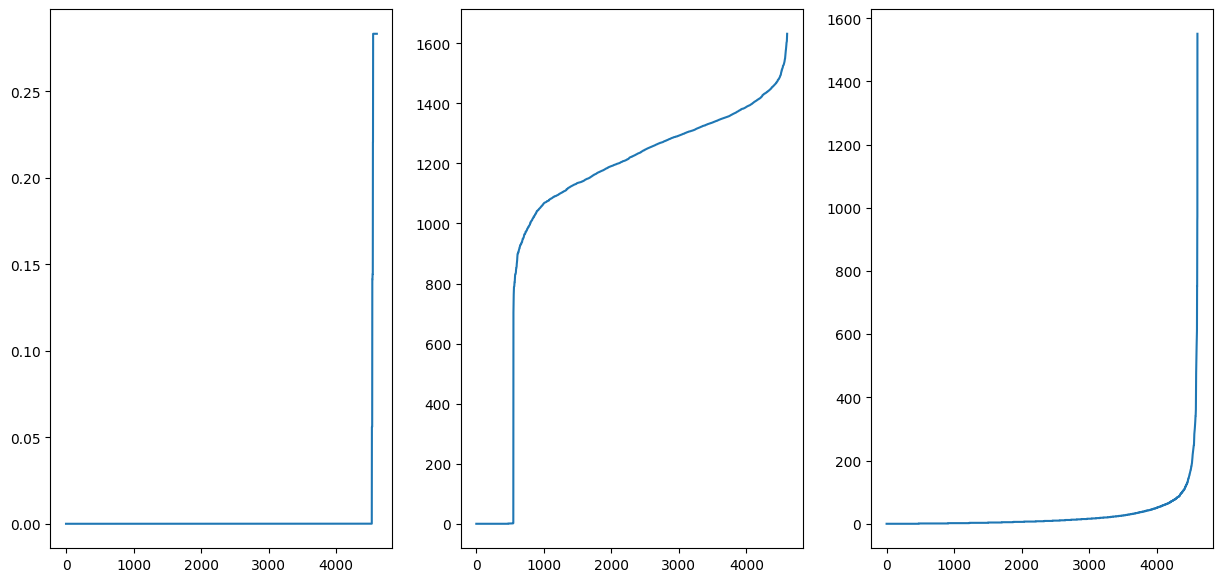

In [312]:
fig, axs = plt.subplots(1,3, figsize=(15,7))
axs[0].plot(sorted(closeness_centralities))
axs[1].plot(sorted(lin_centralities))
axs[2].plot(sorted(harmonic_centralities))

In [313]:
rankings_closeness = sorted([i for i in range(len(articles))], key=lambda x : closeness_centralities[x])
rankings_lin = sorted([i for i in range(len(articles))], key=lambda x : lin_centralities[x])
rankings_harmonic = sorted([i for i in range(len(articles))], key=lambda x : harmonic_centralities[x])

In [314]:
def permute(x, perm):
    return [x[i] for i in perm]

def mtop_5(articles, rankings):
    return permute(articles, rankings)[-5:]
print("=== Closeness measure top 5 ===") 
print(mtop_5(articles,rankings_closeness))
print("=== Lin measure top 5 ===") 
print(mtop_5(articles,rankings_lin))
print("=== Harmonic measure top 5 ===") 
print(mtop_5(articles,rankings_harmonic))

=== Closeness measure top 5 ===
['Weakest_Link', 'Western_painting', 'Whitney_Joins_The_JAMs', 'William_Edington', 'Yuri_Knorosov']
=== Lin measure top 5 ===
['China', 'United_Kingdom', 'Latin', 'Europe', 'United_States']
=== Harmonic measure top 5 ===
['World_War_II', 'Europe', 'France', 'United_Kingdom', 'United_States']


In [318]:
adj_list['Basil_Brush'], adj_list['Weakest_Link']

({'Weakest_Link'}, {'Basil_Brush'})

# Challenges
- HyperLogLog needs corrections apart from $\alpha_p$ that were not mentioned in the paper, but are mentioned in the original HyperLogLog paper, without which, the counts went up to 40000 for a set of 300 distinct items in preliminary testing 
- Pseudo code of the algorithm is not complete, like the initialization for the counters for ball sizes of 1
- It was not clear that all the counters can remain fixed per iteration
- The closeness measure did not work because some nodes were only adjacent to themselves and had measure of 1 and where shown as the top results. As it was mentioned in the paper, the metric was not designed for graphs that were not strongly connected. And there is inherent bias for nodes that are in a very small connected component. Although that was fixed, there were still some subgraphs that were disconnected from the rest of the graph which were of size 2 or 3 and they are showing first in the results, when considering the closeness centrality

# Can the algorithm be easily parallelized?

The algorithm fits very easily in the GAS framework that is used by many distributed graph systems. 
That is because for each iteration we modify each vertex counter using the counters from the previous 
iteration. We can parallelize this by having one thread per vertex in each iteration for example. Additionally, ach iteration then would be a superstep in systems like Pregel

# Does the algorithm work for unbounded graph streams? Explain.

The algorithm as it is does not work for unbounded graph streams. The reason for this is because, we need to know all the adjacency lists from the start, because for every iteration we need to combine information across all the graph. It works very similarly to Page Rank.

# Does the algorithm support edge deletions? If not, what modification would it need? Explain.

Whenever we modify an edge, a huge number of shortest paths may be altered. Because of the way hyperloglog counters work, we cannot know how many times an element has been seen and for this reason we cannot change the ball representations. The algorithm would require recomputation of the hyperballs in this case.

In [197]:
## Nikolaos Smyrnioudis